# Обучение эмбеддингов (Metric Learning)
Данные, необходимые для этого модуля:
* symbol_a1.png
* symbol_a2.png
* symbol_b1.png

## Переключение версии TensorFlow

In [ ]:
%tensorflow_version 2.x

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf

## Загрузка и подготовка датасета MNIST

In [ ]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

train_x = train_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.

11493376/11490434 [==============================] - 0s 0us/step


## Визуализация датасета MNIST

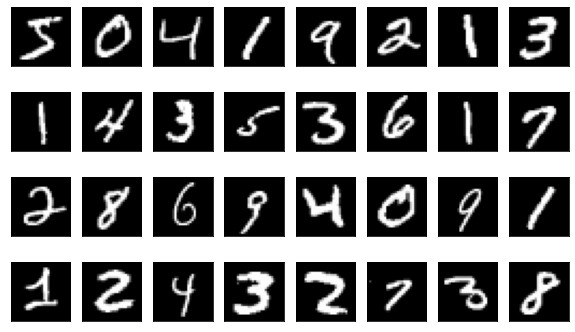

In [ ]:
some_samples = train_x[:32, ...]

fig = plt.figure(figsize=(10, 6))
for j in range(some_samples.shape[0]):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j,:,:,0], cmap='gray')
    plt.xticks([]), plt.yticks([])
plt.show()

## Создание модели CNN

In [ ]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

## Contrastive Loss

In [ ]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

## Подготовка пайплайна данных

In [ ]:
BATCH_SIZE = 64
NUM_EPOCHS = 4

train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

## Подготовка к обучению

In [ ]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## Обучение модели

In [ ]:
%%time

for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 87.79620361328125
[200] Loss: 3.6933140754699707
[400] Loss: 5.127382278442383
[600] Loss: 1.3181016445159912
[800] Loss: 2.1991028785705566
[1000] Loss: 4.067452907562256
[1200] Loss: 3.4208667278289795
[1400] Loss: 0.722781777381897
[1600] Loss: 0.9539313316345215
[1800] Loss: 2.6501026153564453
[2000] Loss: 0.4324076175689697
[2200] Loss: 1.4318313598632812
[2400] Loss: 2.7809863090515137
[2600] Loss: 0.22016502916812897
[2800] Loss: 0.3058619797229767
[3000] Loss: 0.6112560629844666
[3200] Loss: 1.433252215385437
[3400] Loss: 0.7938181161880493
[3600] Loss: 6.04514741897583
CPU times: user 36.3 s, sys: 1.1 s, total: 37.4 s
Wall time: 41.7 s


## Получение эмбеддингов для тестовой выборки

In [ ]:
test_embs = model(test_x)

## Функция для визуализации эмбеддингов

In [ ]:
def draw_embeddings(X_embedded, targets, labels):
    plt.figure(figsize=(10, 10))
    for class_idx in range(np.max(targets)+1):
        X_embedded_class = X_embedded[targets == class_idx, :]
        plt.scatter(X_embedded_class[:,0], X_embedded_class[:,1])
    plt.legend(labels, loc='best')
    plt.grid(True)

## Визуализация образцов MNIST в 2D пространстве с помощью TSNE

In [ ]:
test_x_flat = test_x.reshape(-1, 28*28)
test_x_2D = TSNE(n_components=2).fit_transform(test_x_flat[:1000])
labels_for_viz = test_y[:1000]

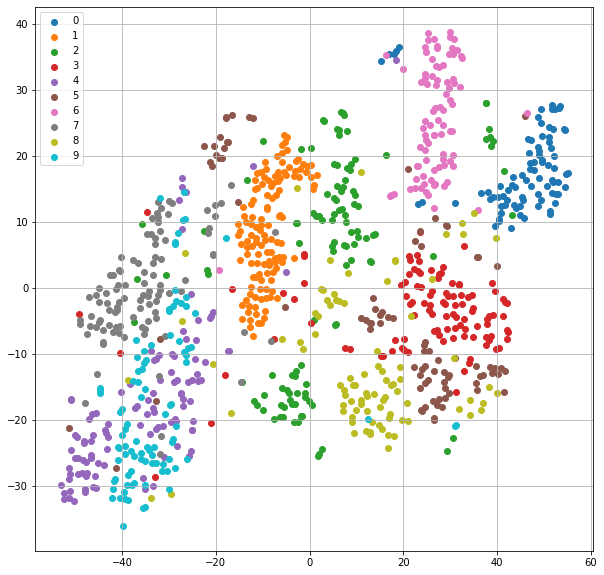

In [ ]:
draw_embeddings(test_x_2D, labels_for_viz, list(range(10)))

## Визуализация эмбеддингов в 2D пространстве с помощью TSNE

In [ ]:
test_embs_2D = TSNE(n_components=2).fit_transform(test_embs[:1000])
labels_for_viz = test_y[:1000]

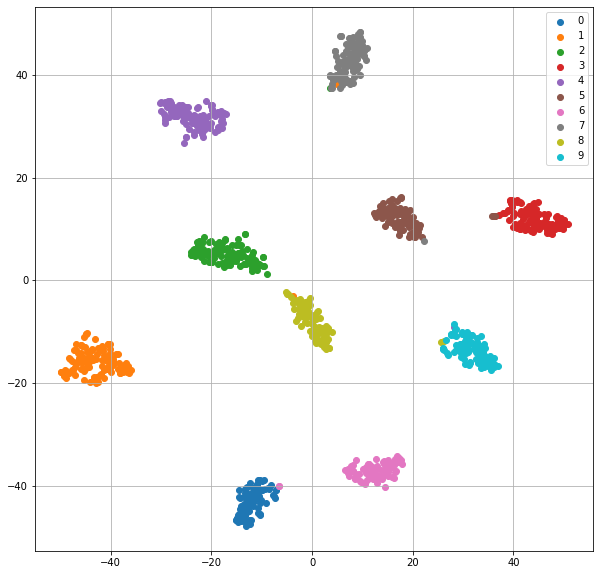

In [ ]:
draw_embeddings(test_embs_2D, labels_for_viz, list(range(10)))

## Тестирование на новых данных

In [ ]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (28, 28), order=3, mode='reflect', anti_aliasing=True)
    img = (1. - img).astype(np.float32)
    img = np.mean(img, axis=2)
    img = np.reshape(img, (28, 28, 1))
    return img

img_a1 = load_and_prepare_image('symbol_a1.png')
img_a2 = load_and_prepare_image('symbol_a2.png')
img_b1 = load_and_prepare_image('symbol_b1.png')

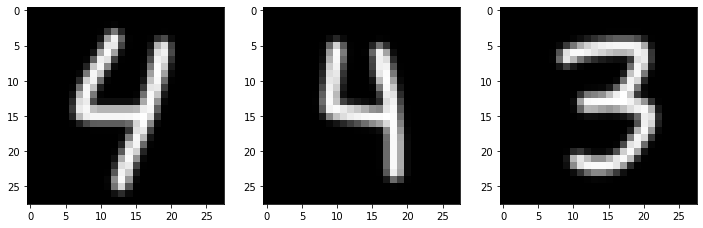

In [ ]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img_a1[:,:,0], cmap='gray')
ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_a2[:,:,0], cmap='gray')
ax = fig.add_subplot(1, 3, 3)
ax.imshow(img_b1[:,:,0], cmap='gray')
plt.show()

## Получение эмбеддингов для новых данных

In [ ]:
new_embs = model(np.stack((img_a1, img_a2, img_b1), axis=0))

## Вычисление расстояний между эмбеддингами

In [ ]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]

print('A1 <-> A2: ', diff(emb1, emb2))
print('A2 <-> B1: ', diff(emb2, emb3))
print('A1 <-> B1: ', diff(emb1, emb3))

A1 <-> A2:  0.864242294948087
A2 <-> B1:  14.130775553699218
A1 <-> B1:  13.549082504684588
